In [1]:
import pandas as pd
from pyspark import SparkContext
import time
import numpy as np
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns
startTime = time.time()

In [2]:
sc = SparkContext("local[*]", "UserUserRating")

In [47]:
trainData = sc.textFile("/Users/apple/Desktop/DataMining/project/user_business_rating_user_sim.csv")
trainDataFirst = trainData.first()
trainData = trainData.filter(lambda x: x != trainDataFirst)
trainData = trainData.map(lambda l: l.split(','))
trainData = trainData.map(lambda x : (x[1],x[2],x[3])).collect()

In [4]:
#trainData = trainData[:40000]

In [48]:
users = {}
businesses = {}
finalInput = []
ratings = []

In [49]:
for i in trainData:
    if users.get(i[0]) is None:
        users[i[0]] = len(users) + 1
    if businesses.get(i[1]) is None:
        businesses[i[1]] = len(businesses) + 1
    ratings.append(float(i[2].strip()))
    finalInput.append([users[i[0]],businesses[i[1]],float(i[2].strip())])

In [50]:
invUsers = {str(v): k for k, v in users.items()}
invBusinesses = {str(v): k for k, v in businesses.items()}

trainAvgRating = [float(sum(col))/len(col) for col in zip(*finalInput)][2]
minVal = min(ratings)
maxVal = max(ratings)


In [51]:
finalTrainInput = sc.parallelize(finalInput)

userAverage = finalTrainInput.map(lambda l: (l[0], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
userAverage = userAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

businesAverage = finalTrainInput.map(lambda l: (l[1], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
businesAverage = businesAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

In [52]:
trainRdd = finalTrainInput
trainRddUsers = trainRdd.map(lambda x : ((str(x[0]), str(x[1])), (float(x[2])-minVal)/(maxVal-minVal)))
trainingRddUsers = trainRddUsers.map(lambda x : (x[0][0], (x[0][1], x[1])))
businessesOnlyUserCF = trainingRddUsers.map(lambda x : (x[1][0], x[0]))
businessesOnlyUserCF = businessesOnlyUserCF.groupByKey()
businessesOnlyUserCF = businessesOnlyUserCF.mapValues(list)
businessesOnlyUserCF = businessesOnlyUserCF.collectAsMap()
userAndBusinessesUserCF = trainingRddUsers.map(lambda x : ((x[0], x[1][0]), x[1][1]))
userAndBusinessesUserCF = userAndBusinessesUserCF.collectAsMap()

usersOnlyUserCF = trainingRddUsers.groupByKey()
usersOnlyUserCF = usersOnlyUserCF.mapValues(list)
usersOnlyUserCF = usersOnlyUserCF.collectAsMap()

In [53]:
def calcPearsonUsers(corratedUsersBusinessess):
    if len(corratedUsersBusinessess) == 0:
        return -100
    if len(corratedUsersBusinessess) == 1:
        return -100
    tempUB = [x[1][0] for x in corratedUsersBusinessess]
    tempUBAvg = sum(tempUB)/len(tempUB)
    pearsonNumerator = 0
    pearsonDenom1 = 0
    pearsonDenom2 = 0
    allUB = [x[1][1] for x in corratedUsersBusinessess]
    for (i, j) in zip(tempUB, allUB):
        pearsonNumerator += (i-tempUBAvg)*(j-tempUBAvg)
        pearsonDenom1 += (i-tempUBAvg)**2
        pearsonDenom2 += (j-tempUBAvg)**2
    pearsonDenom = (pearsonDenom1**0.5) * (pearsonDenom2**0.5)
    if pearsonDenom == 0 or pearsonNumerator == 0:
        return -100
    else:
        return pearsonNumerator/pearsonDenom

In [54]:
user_ids = usersOnlyUserCF.keys()

In [55]:
user_vs_business ={}
import pandas as pd
for k , v in usersOnlyUserCF.items():
    user_vs_business [k] =  len(v)
data = {"user" : user_vs_business.keys() , "count_business" : user_vs_business.values()}
df =  pd.DataFrame.from_dict(data)
df_new = df[ (df.count_business <100 ) & ( df.count_business >30 )]


In [56]:
user_ids =df_new.user.unique()

In [57]:
len(user_ids)

4268

In [58]:
pearson_between_users= []

In [59]:
for i,user1 in enumerate(user_ids[:-1]):
    for j , user2 in enumerate(user_ids[i+1:]):
        eachUserInfo = usersOnlyUserCF[user1]
        tempKnnUsersInfo = usersOnlyUserCF[user2]
        corratedUsersBusinessess = []
        tempKnnUsersInfo.sort()
        eachUserInfo.sort()
        l= 0
        k = 0
        while l<len(tempKnnUsersInfo) and k< len(eachUserInfo):
            if tempKnnUsersInfo[l][0] == eachUserInfo[k][0]:
                corratedUsersBusinessess.append((tempKnnUsersInfo[l][0], (tempKnnUsersInfo[l][1], eachUserInfo[k][1])))
                l = l+1
                k = k+1
            elif tempKnnUsersInfo[l][0] < eachUserInfo[k][0]:
                l = l+1
            else:
                k = k+1
       
        pearsonRating = calcPearsonUsers(corratedUsersBusinessess)
        if pearsonRating != -100:
            pearson_between_users.append((user1,user2,pearsonRating))

In [60]:
pearson_between_users

[('44884', '12010', 0.9999999999999998),
 ('44884', '42818', -0.6761234037828137),
 ('44884', '38564', -0.447213595499958),
 ('44884', '13987', -0.4999999999999999),
 ('44884', '17354', -1.7663540160192474e-16),
 ('44884', '49155', -0.17094086468945702),
 ('44884', '28404', -0.40824829046386296),
 ('44884', '794', -0.4472135954999579),
 ('44884', '38972', 0.9999999999999998),
 ('44884', '48870', -0.447213595499958),
 ('44884', '23698', 0.9999999999999998),
 ('44884', '12001', 0.16439898730535726),
 ('44884', '191', -0.4472135954999579),
 ('44884', '14145', -0.447213595499958),
 ('44884', '28051', -0.9999999999999998),
 ('44884', '34747', 0.4999999999999999),
 ('44884', '38808', 0.8040302522073697),
 ('44884', '44993', 0.6708203932499366),
 ('44884', '13900', -0.5455447255899809),
 ('44884', '13908', 1.0000000000000002),
 ('44884', '19059', 0.3235751144647169),
 ('44884', '16995', -0.9999999999999998),
 ('44884', '22446', -0.4472135954999579),
 ('44884', '8142', 0.2182178902359924),
 ('

In [61]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession(sc)

In [62]:
pearson_rdd = sc.parallelize(pearson_between_users)

In [63]:

pearson_rdd = sc.parallelize(pearson_between_users)  


# convert to code and Use below to dump user-user pearson to file

In [64]:
pearson_rdd

ParallelCollectionRDD[63] at parallelize at PythonRDD.scala:184

In [65]:
def p(x):
    print(x)
    
pearson_rdd.foreach(p)

In [66]:
import pandas as pd
import numpy as np
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
#unweighted graph creation

In [67]:
pearson_rdd=pearson_rdd.toDF()

In [68]:
pearson_df=pearson_rdd.toPandas()

In [70]:
pearson_df.head(10)

,_1,_2,_3
0,44884,12010,1.000000e+00
1,44884,42818,-6.761234e-01
2,44884,38564,-4.472136e-01
3,44884,13987,-5.000000e-01
4,44884,17354,-1.766354e-16
5,44884,49155,-1.709409e-01
6,44884,28404,-4.082483e-01
7,44884,794,-4.472136e-01
8,44884,38972,1.000000e+00
9,44884,48870,-4.472136e-01


In [71]:
pearson_df.count()

_1    590933
_2    590933
_3    590933
dtype: int64

In [72]:
pearson_df["_3"].describe()

count    590933.000000
mean          0.093595
std           0.619299
min          -1.000000
25%          -0.447214
50%           0.166667
75%           0.618718
max           1.000000
Name: _3, dtype: float64

In [74]:
pearson_df.to_csv("USER_USER_30_100.csv")

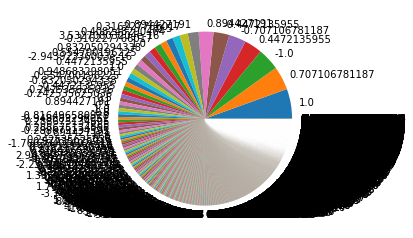

In [73]:
pearson_df["_3"].value_counts().plot.pie()
plt.gca().set_aspect("equal")


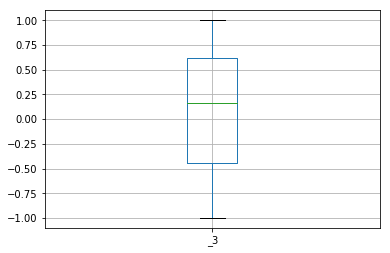

In [75]:
boxplot = pearson_df.boxplot(column=["_3"])

In [77]:
data = pearson_df[(pearson_df._3 > -0.4) &  (pearson_df._3 < 0.6) ]

In [78]:
data.count()

_1    277576
_2    277576
_3    277576
dtype: int64

In [79]:
G = nx.from_pandas_edgelist(data, "_1", "_2", ["_3"])

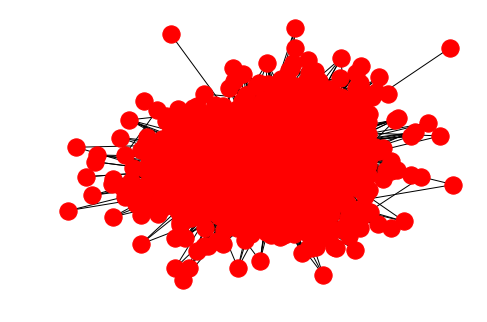

In [80]:
nx.draw(G)
plt.show()

In [81]:
nx.classes.function.density(G)

0.030583752849570236

In [82]:
comp = nx.algorithms.community.centrality.girvan_newman(G)

In [ ]:
cnt=0
d={}

for c in next(comp):
    #print(c)
    d[cnt]=len(c)
    #print(len(c))
    #print("\n")
    cnt+=1
print("number of communities"+str(cnt))    
print(d)
    

In [46]:
comp

<generator object girvan_newman at 0x11e618820>

In [ ]:

>>> G = nx.path_graph(10)
>>> edges = G.edges()
>>> nx.set_edge_attributes(G, {(u, v): v for u, v in edges}, 'weight')
>>> def heaviest(G):
...     u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
...     return (u, v)
...
>>> comp = girvan_newman(G, most_valuable_edge=heaviest)

In [ ]:
#weighted community creation
from operator import itemgetter
G = nx.from_pandas_edgelist(data, "_1", "_2", ["_3"])
nx.draw(G)
plt.show()
nx.classes.function.density(G)
def heaviest(G):
    u, v, w = min(G.edges(data='_3'), key=itemgetter(2))
    return (u, v)

comp = girvan_newman(G, most_valuable_edge=heaviest)